# Income Classifier on Adult Dataset

Classifier to predict whether someone will have income ">50K".

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from aif360.datasets import AdultDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## 2. Load the Adult Dataset

In [2]:
dataset = AdultDataset()

df = pd.DataFrame(dataset.features, columns=dataset.feature_names)
df['income'] = dataset.labels.ravel() # Converts to 1D array

print(f"Dataset shape: {df.shape}")
print(df.head(30))
print(f"Income distribution:")
print(df['income'].value_counts())


Dataset shape: (45222, 99)
     age  education-num  race  sex  capital-gain  capital-loss  \
0   25.0            7.0   0.0  1.0           0.0           0.0   
1   38.0            9.0   1.0  1.0           0.0           0.0   
2   28.0           12.0   1.0  1.0           0.0           0.0   
3   44.0           10.0   0.0  1.0        7688.0           0.0   
4   34.0            6.0   1.0  1.0           0.0           0.0   
5   63.0           15.0   1.0  1.0        3103.0           0.0   
6   24.0           10.0   1.0  0.0           0.0           0.0   
7   55.0            4.0   1.0  1.0           0.0           0.0   
8   65.0            9.0   1.0  1.0        6418.0           0.0   
9   36.0           13.0   1.0  1.0           0.0           0.0   
10  26.0            9.0   1.0  0.0           0.0           0.0   
11  48.0            9.0   1.0  1.0        3103.0           0.0   
12  43.0           14.0   1.0  1.0           0.0           0.0   
13  20.0           10.0   1.0  1.0           0.0 

In [3]:
print(df['age'].describe()) # summary statistics for the 'age' column

count    45222.000000
mean        38.547941
std         13.217870
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64


## 3. Preprocess the Data and Binarize Age

### 3.1 Init age variables (mean and median)

In [4]:
# TODO: add "mean" value for binarizing age threshold for comparison  -------------OK

print(df.isna().any())

missing_data = df['age'].isnull().sum()
print(f"Missing data in 'age' column: {missing_data}")


age                               False
education-num                     False
race                              False
sex                               False
capital-gain                      False
                                  ...  
native-country=Trinadad&Tobago    False
native-country=United-States      False
native-country=Vietnam            False
native-country=Yugoslavia         False
income                            False
Length: 99, dtype: bool
Missing data in 'age' column: 0


In [5]:
# Binarize age based on median
age_median = df['age'].median() # will be the threshold for binarization
print(f"Age median: {age_median}")

df['age_binary_median'] = (df['age'] > age_median).astype(int)

print(f"Binarized age distribution:")
print(df['age_binary_median'].value_counts())

Age median: 37.0
Binarized age distribution:
age_binary_median
0    23027
1    22195
Name: count, dtype: int64


In [6]:
#b Binarize age based on mean
age_mean = round(df['age'].mean(), 2) # will be the threshold for binarization
print(f"Mean age: {age_mean}")

df['age_binary_mean'] = (df['age'] > age_mean).astype(float)

print(f"Binarized age distribution:")
print(df['age_binary_mean'].value_counts())

Mean age: 38.55
Binarized age distribution:
age_binary_mean
0.0    24238
1.0    20984
Name: count, dtype: int64


### 3.2 Construction de X_median

Features shape: (45222, 98)
Target shape: (45222,)
Feature names: ['education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-AF-spouse', 'marital-status=Married-civ-spouse', 'marital-status=Married-spouse-absent', 'marital-status=Never-married', 'marital-status=Separated', 'marital-status=Widowed', 'occupation=Adm-clerical', 'occupation=Armed-Forces', 'occupation=Craft-repair', 'occupation=Exec-managerial'

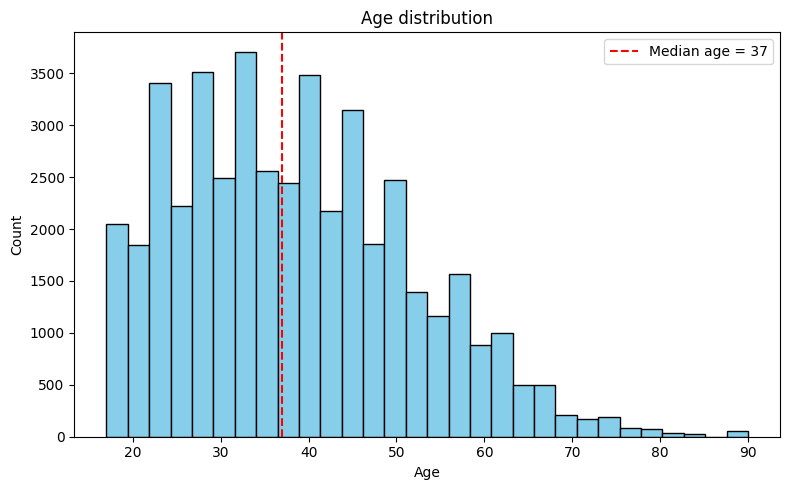

In [7]:
# Drop the original age column and use the binarized version
X = df.drop(['income', 'age','age_binary_mean'], axis=1)  # all the features that the model will use for prediction
y = df['income'] # what we are trying to predict

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")

# Histogram visualization for age distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['age'].dropna(), bins=30, color='skyblue', edgecolor='k')
plt.axvline(age_median, color='red', linestyle='--', label=f'Median age = {int(age_median)}')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

### 3.2 For mean value of age :

Features shape: (45222, 98)
Target shape: (45222,)
Feature names: ['education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-AF-spouse', 'marital-status=Married-civ-spouse', 'marital-status=Married-spouse-absent', 'marital-status=Never-married', 'marital-status=Separated', 'marital-status=Widowed', 'occupation=Adm-clerical', 'occupation=Armed-Forces', 'occupation=Craft-repair', 'occupation=Exec-managerial'

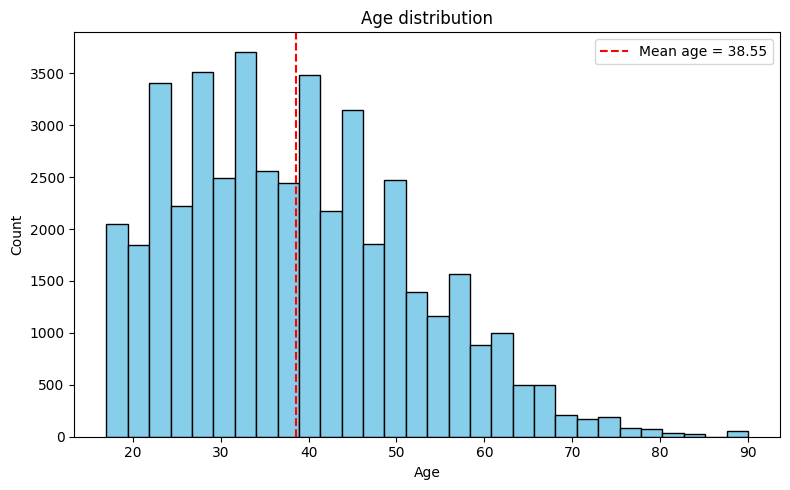

In [8]:
# Drop the original age column and use the binarized version
X_mean = df.drop(['income', 'age','age_binary_median'], axis=1)  # all the features that the model will use for prediction
y_mean = df['income'] # what we are trying to predict

print(f"Features shape: {X_mean.shape}")
print(f"Target shape: {y_mean.shape}")
print(f"Feature names: {list(X_mean.columns)}")

# Histogram visualization for age distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['age'].dropna(), bins=30, color='skyblue', edgecolor='k')
plt.axvline(age_mean, color='red', linestyle='--', label=f'Mean age = {float(age_mean)}')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
print(X_mean.head(10))
print(X.head(10))

   education-num  race  sex  capital-gain  capital-loss  hours-per-week  \
0            7.0   0.0  1.0           0.0           0.0            40.0   
1            9.0   1.0  1.0           0.0           0.0            50.0   
2           12.0   1.0  1.0           0.0           0.0            40.0   
3           10.0   0.0  1.0        7688.0           0.0            40.0   
4            6.0   1.0  1.0           0.0           0.0            30.0   
5           15.0   1.0  1.0        3103.0           0.0            32.0   
6           10.0   1.0  0.0           0.0           0.0            40.0   
7            4.0   1.0  1.0           0.0           0.0            10.0   
8            9.0   1.0  1.0        6418.0           0.0            40.0   
9           13.0   1.0  1.0           0.0           0.0            40.0   

   workclass=Federal-gov  workclass=Local-gov  workclass=Private  \
0                    0.0                  0.0                1.0   
1                    0.0              

## 4. Split Data into Train, Validation, and Test Sets

### 4.1. For median ages

In [10]:
#TODO : test with different split percentages and compare results
# Split: 60% train, 20% validation, 20% test
# First split: 60% train, 40% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y #stratify to maintain class distribution : important for imbalanced datasets
)

# Second split: Split temp into 50% validation, 50% test (20% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"Class distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"Class distribution in validation set:")
print(y_val.value_counts(normalize=True))
print(f"Class distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set size: 27133 (60.0%)
Validation set size: 9044 (20.0%)
Test set size: 9045 (20.0%)
Class distribution in training set:
income
0.0    0.752147
1.0    0.247853
Name: proportion, dtype: float64
Class distribution in validation set:
income
0.0    0.752211
1.0    0.247789
Name: proportion, dtype: float64
Class distribution in test set:
income
0.0    0.752128
1.0    0.247872
Name: proportion, dtype: float64


### 4.2. For mean ages

In [11]:
#TODO : test with different split percentages and compare results   -------------OK
# Split: 60% train, 20% validation, 20% test
# First split: 60% train, 40% temp (validation + test)
X_train_mean, X_temp_mean, y_train_mean, y_temp_mean = train_test_split(
    X_mean, y_mean, test_size=0.4, random_state=42, stratify=y_mean #stratify to maintain class distribution : important for imbalanced datasets
)

# Second split: Split temp into 50% validation, 50% test (20% each of total)
X_val_mean, X_test_mean, y_val_mean, y_test_mean = train_test_split(
    X_temp_mean, y_temp_mean, test_size=0.5, random_state=42, stratify=y_temp_mean
)

print(f"Training set size: {X_train_mean.shape[0]} ({X_train_mean.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val_mean.shape[0]} ({X_val_mean.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test_mean.shape[0]} ({X_test_mean.shape[0]/len(X)*100:.1f}%)")

print(f"Class distribution in training set:")
print(y_train_mean.value_counts(normalize=True))
print(f"Class distribution in validation set:")
print(y_val_mean.value_counts(normalize=True))
print(f"Class distribution in test set:")
print(y_test_mean.value_counts(normalize=True))

Training set size: 27133 (60.0%)
Validation set size: 9044 (20.0%)
Test set size: 9045 (20.0%)
Class distribution in training set:
income
0.0    0.752147
1.0    0.247853
Name: proportion, dtype: float64
Class distribution in validation set:
income
0.0    0.752211
1.0    0.247789
Name: proportion, dtype: float64
Class distribution in test set:
income
0.0    0.752128
1.0    0.247872
Name: proportion, dtype: float64


## 5. Feature Scaling

The idea is to put features on a similar scale so that no single feature dominates the learning process due to its magnitude. This is especially important for algorithms like Logistic Regression, which are sensitive to the scale of input features.

## 5.1. For median age

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # computes mean and std, then scales
X_val_scaled = scaler.transform(X_val) # scales validation set
X_test_scaled = scaler.transform(X_test) # scales test set

print("Features scaled using StandardScaler")
print(f"Training set scaled shape: {X_train_scaled.shape}")
print(f"Validation set scaled shape: {X_val_scaled.shape}")
print(f"Test set scaled shape: {X_test_scaled.shape}")

Features scaled using StandardScaler
Training set scaled shape: (27133, 98)
Validation set scaled shape: (9044, 98)
Test set scaled shape: (9045, 98)


## 5.2. For mean age

In [13]:
scaler_mean = StandardScaler()
X_train_mean_scaled = scaler_mean.fit_transform(X_train_mean) # computes mean and std, then scales
X_val_mean_scaled = scaler_mean.transform(X_val_mean) # scales validation set
X_test_mean_scaled = scaler_mean.transform(X_test_mean) # scales test set

print("Features scaled using StandardScaler")
print(f"Training set scaled shape: {X_train_mean_scaled.shape}")
print(f"Validation set scaled shape: {X_val_mean_scaled.shape}")
print(f"Test set scaled shape: {X_test_mean_scaled.shape}")

Features scaled using StandardScaler
Training set scaled shape: (27133, 98)
Validation set scaled shape: (9044, 98)
Test set scaled shape: (9045, 98)


## 6. Train the Classifier

## 6.1. For median age

In [14]:
#TODO :test with different models and compare results
#TODO : save models into .pth files, reusable in further notebooks. -------------OK
# Logistic Regression
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train_scaled, y_train)
print("Logistic Regression trained")

#TODO : visualize training error epochs / training metrics too (accuracy, precision, recall, f1-score)

Logistic Regression trained


### Saving "The Classifier"

This is **the base classifier** referenced in the project statement (Section 1: Classification). 
We save it with a clear name for reuse in subsequent tasks (Fairness, Privacy, etc.).

In [15]:
import joblib
import os

# 1. Create a folder for the models 
os.makedirs("models", exist_ok=True)

# 2. Build an object that contains everything we want to save
artifact = {
    "model": lr_classifier,      # the trained classifier
    "scaler": scaler,            # the trained StandardScaler
    "feature_names": X.columns   # to keep the column order
}

# 3. Save THE CLASSIFIER (base model for the project)
joblib.dump(artifact, "models/the_classifier.joblib")

# Also save with descriptive name for reference
joblib.dump(artifact, "models/logreg_adult_age_median.joblib")

print("✓ THE CLASSIFIER saved as: models/the_classifier.joblib")
print("  (Also saved as: models/logreg_adult_age_median.joblib for reference)")

✓ THE CLASSIFIER saved as: models/the_classifier.joblib
  (Also saved as: models/logreg_adult_age_median.joblib for reference)


## 6.2. For mean age:

In [16]:
lr_classifier_mean_age = LogisticRegression(max_iter=1000)
lr_classifier_mean_age.fit(X_train_mean_scaled, y_train_mean)
print("Logistic Regression trained")

Logistic Regression trained


### Saving alternative model (mean age)

This is an alternative classifier using mean age instead of median for binarization.
Saved for comparison purposes, but **the_classifier.joblib** is the primary one.

In [17]:
# 1. Create a folder for the models 
os.makedirs("models", exist_ok=True)

# 2. Build an object that contains everything we want to save
artifact = {
    "model": lr_classifier_mean_age,      # the trained classifier
    "scaler": scaler_mean,            # the trained StandardScaler
    "feature_names": X_mean.columns   # to keep the column order
}

# 3. Save it into a file
joblib.dump(artifact, "models/logreg_adult_age_mean.joblib")

print("Model saved in models/logreg_adult_age_mean.joblib")

Model saved in models/logreg_adult_age_mean.joblib


## 7. Measure Performance on Validation Set

## 7.1. for age median

In [18]:
# TODO : add confusion matrix visualization -------------OK
# Predict on validation set
y_val_pred = lr_classifier.predict(X_val_scaled)

# Calculate validation metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("VALIDATION SET PERFORMANCE")
print("="*50)
print(f"Accuracy:  {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall:    {val_recall:.4f}")
print(f"F1-Score:  {val_f1:.4f}")

print("Detailed Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['<=50K', '>50K']))

VALIDATION SET PERFORMANCE
Accuracy:  0.8470
Precision: 0.7330
Recall:    0.6015
F1-Score:  0.6608
Detailed Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6803
        >50K       0.73      0.60      0.66      2241

    accuracy                           0.85      9044
   macro avg       0.80      0.76      0.78      9044
weighted avg       0.84      0.85      0.84      9044




Confusion Matrix:
[[6312  491]
 [ 893 1348]]


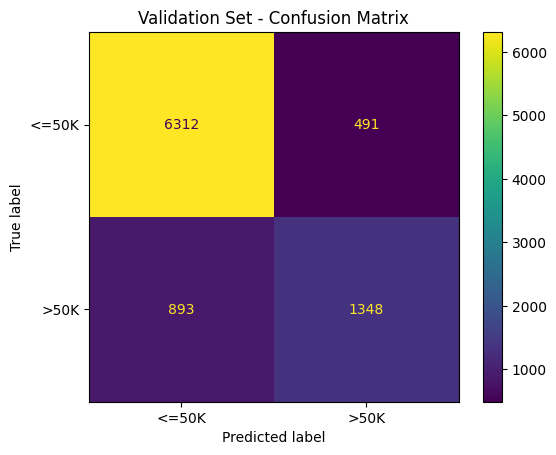

In [19]:
cm_model_median = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm_model_median)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_model_median, display_labels=['<=50K', '>50K'])
disp.plot()
plt.title("Validation Set - Confusion Matrix")
plt.show()

In [20]:
#TODO : visualize training and validation error evolution over epochs

## 7.2. For age mean

In [21]:
# TODO : add confusion matrix visualization -------------OK
# Predict on validation set
y_val_pred_mean = lr_classifier_mean_age.predict(X_val_mean_scaled)

# Calculate validation metrics
val_accuracy_mean = accuracy_score(y_val_mean, y_val_pred_mean)
val_precision_mean = precision_score(y_val_mean, y_val_pred_mean)
val_recall_mean = recall_score(y_val_mean, y_val_pred_mean)
val_f1_mean = f1_score(y_val_mean, y_val_pred_mean)

print("VALIDATION SET PERFORMANCE")
print("="*50)
print(f"Accuracy:  {val_accuracy_mean:.4f}")
print(f"Precision: {val_precision_mean:.4f}")
print(f"Recall:    {val_recall_mean:.4f}")
print(f"F1-Score:  {val_f1_mean:.4f}")

print("Detailed Classification Report:")
print(classification_report(y_val_mean, y_val_pred_mean, target_names=['<=50K', '>50K']))


VALIDATION SET PERFORMANCE
Accuracy:  0.8465
Precision: 0.7302
Recall:    0.6037
F1-Score:  0.6610
Detailed Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6803
        >50K       0.73      0.60      0.66      2241

    accuracy                           0.85      9044
   macro avg       0.80      0.77      0.78      9044
weighted avg       0.84      0.85      0.84      9044




Confusion Matrix:
[[6303  500]
 [ 888 1353]]


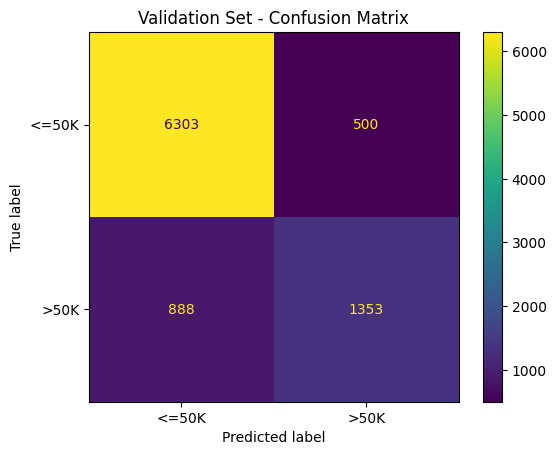

In [22]:
cm_model_mean = confusion_matrix(y_val_mean, y_val_pred_mean)
print("\nConfusion Matrix:")
print(cm_model_mean)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_model_mean, display_labels=['<=50K', '>50K'])
disp.plot()
plt.title("Validation Set - Confusion Matrix")
plt.show()

## 8. Measure Performance on Test Set

In [23]:
# Predict on test set
y_test_pred = lr_classifier.predict(X_test_scaled)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("TEST SET PERFORMANCE")
print("="*50)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")

print("Detailed Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['<=50K', '>50K']))


TEST SET PERFORMANCE
Accuracy:  0.8442
Precision: 0.7272
Recall:    0.5946
F1-Score:  0.6542
Detailed Classification Report:
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      6803
        >50K       0.73      0.59      0.65      2242

    accuracy                           0.84      9045
   macro avg       0.80      0.76      0.78      9045
weighted avg       0.84      0.84      0.84      9045

